In [762]:
# import libraries here
import random
import os as os
import requests
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
#from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import LSTM, Dense, LeakyReLU, Bidirectional, GRU, Dropout
from tensorflow.keras.losses import Huber, MeanSquaredError
from tensorflow.keras.optimizers import SGD, Adadelta, Ftrl

In [763]:
data_frame = pd.read_excel('Raw_Data/Labour_Market_Overview_DEC2024.xls', sheet_name=8, skiprows=6, nrows=186)
print(data_frame)

    SIC 2007 sections    A    B     C    D    E     F     G     H     I  ...  \
0            Jun 1978  520  383  6732  251  153  1887  3971  1389  1171  ...   
1            Sep 1978  512  376  6727  255  155  1894  4006  1391  1175  ...   
2            Dec 1978  512  373  6724  256  156  1913  4060  1393  1211  ...   
3            Mar 1979  507  374  6708  257  156  1918  4067  1395  1219  ...   
4            Jun 1979  509  374  6704  257  157  1931  4097  1397  1228  ...   
..                ...  ...  ...   ...  ...  ...   ...   ...   ...   ...  ...   
181         Sep 2023   377   51  2599  126  242  2247  4761  1848  2680  ...   
182         Dec 2023   403   50  2599  130  240  2213  4766  1909  2643  ...   
183         Mar 2024   372   48  2579  131  246  2234  4776  1907  2666  ...   
184         Jun 2024   350   50  2572  137  242  2158  4752  1882  2683  ...   
185          Sep 2024  361   46  2580  141  242  2227  4741  1883  2702  ...   

        M     N     O     P     Q     R

In [764]:
# No missing data

# Plot data to see any outliers

# First change the column names to make the data easier to read

data_frame = data_frame.rename(columns={'A': 'Agriculture, forestry & fishing', 
                                        'B': 'Mining & quarrying',
                                        'C': 'Manufacturing',
                                        'D': 'Electricity, gas, steam & air conditioning supply',
                                        'E': 'Water supply, sewerage, waste & remediation activities',
                                        'F': 'Construction',
                                        'G': 'Wholesale & retail trade; repair of motor vehicles and motorcycles',
                                        'H': 'Transport & storage',
                                        'I': 'Accommodation & food service activities',
                                        'J': 'Information & communication',
                                        'K': 'Financial & insurance activities',
                                        'L': 'Real estate activities',
                                        'M': 'Professional scientific & technical activities',
                                        'N': 'Administrative & support service activities',
                                        'O': 'Public admin & defence; compulsory social security',
                                        'P': 'Education',
                                        'Q': 'Human health & social work activities',
                                        'R': 'Arts, entertainment & recreation',
                                        'S': 'Other service activities',
                                        'T': 'Private households',
                                        'G-T' : 'Total Services',
                                        'A-T': 'All Jobs'})

data_frame = data_frame.drop(columns=['Total Services', 'All Jobs'])
data_frame = data_frame.rename(columns={'SIC 2007 sections': 'Year-Month'})
data_frame['Year-Month'] = data_frame['Year-Month'].str.replace(r"\(r\)|\(p\)","", regex=True).str.strip() #gets rid of the r and p values on the dates
data_frame['Year-Month'] = pd.to_datetime(data_frame['Year-Month'], format = '%b %Y', errors = 'coerce')
data_frame.set_index('Year-Month', inplace=True)
data_frame.index = data_frame.index.strftime('%Y-%m')
data_frame.index = pd.to_datetime(data_frame.index)
data_frame.to_csv('Processed_Data/Labour_Market_Overview.csv')

print(data_frame)
data_frame_copy = data_frame

            Agriculture, forestry & fishing  Mining & quarrying  \
Year-Month                                                        
1978-06-01                              520                 383   
1978-09-01                              512                 376   
1978-12-01                              512                 373   
1979-03-01                              507                 374   
1979-06-01                              509                 374   
...                                     ...                 ...   
2023-09-01                              377                  51   
2023-12-01                              403                  50   
2024-03-01                              372                  48   
2024-06-01                              350                  50   
2024-09-01                              361                  46   

            Manufacturing  Electricity, gas, steam & air conditioning supply  \
Year-Month                                      

In [765]:
print(data_frame['Information & communication'])

Year-Month
1978-06-01     781
1978-09-01     783
1978-12-01     787
1979-03-01     789
1979-06-01     791
              ... 
2023-09-01    1589
2023-12-01    1633
2024-03-01    1623
2024-06-01    1615
2024-09-01    1638
Name: Information & communication, Length: 186, dtype: int64


In [794]:
# Plot data

plt.figure(figsize = (200,50))

number_of_unique_sectors = data_frame.columns.tolist()

colours_for_each_sector = cm.tab20.colors
colour_map = {sector: colours_for_each_sector[i%len(colours_for_each_sector)] for i, sector in enumerate(number_of_unique_sectors)}

for column in data_frame.columns:
    plt.plot(data_frame.index, data_frame[column], label = column, linewidth = 10, color = colour_map[column])

plt.xlabel('Date (YEAR - MONTH)', fontsize=40)
plt.ylabel('Number of Workforce Jobs (1000s)', fontsize=40)
plt.xticks(fontsize=28, rotation=90)
plt.yticks(fontsize=28)
plt.title('The Number of People Employed over the Last 46 years and 3 months per Employment Sector', fontsize=40)
plt.legend(title = "Sector", bbox_to_anchor = (1,1), loc = 'upper left', fontsize=40)
plt.tight_layout()
plt.show()

In [795]:
# Testing for NaNs

print(data_frame.isna().sum())

Agriculture, forestry & fishing                                       0
Mining & quarrying                                                    0
Manufacturing                                                         0
Electricity, gas, steam & air conditioning supply                     0
Water supply, sewerage, waste & remediation activities                0
Construction                                                          0
Wholesale & retail trade; repair of motor vehicles and motorcycles    0
Transport & storage                                                   0
Accommodation & food service activities                               0
Information & communication                                           0
Financial & insurance activities                                      0
Real estate activities                                                0
Professional scientific & technical activities                        0
Administrative & support service activities                     

In [796]:
# Testing for Infinite Values

print(np.isinf(data_frame).sum())

Agriculture, forestry & fishing                                       0
Mining & quarrying                                                    0
Manufacturing                                                         0
Electricity, gas, steam & air conditioning supply                     0
Water supply, sewerage, waste & remediation activities                0
Construction                                                          0
Wholesale & retail trade; repair of motor vehicles and motorcycles    0
Transport & storage                                                   0
Accommodation & food service activities                               0
Information & communication                                           0
Financial & insurance activities                                      0
Real estate activities                                                0
Professional scientific & technical activities                        0
Administrative & support service activities                     

In [797]:
# Testing for Large Values

print(data_frame.describe())

       Agriculture, forestry & fishing  Mining & quarrying  Manufacturing  \
count                       186.000000          186.000000     186.000000   
mean                        436.612903          125.623656    3844.392473   
std                          57.424363          100.705287    1202.386470   
min                         335.000000           46.000000    2537.000000   
25%                         383.250000           62.000000    2649.250000   
50%                         425.000000           73.500000    3803.500000   
75%                         496.000000          162.500000    4934.000000   
max                         521.000000          383.000000    6732.000000   

       Electricity, gas, steam & air conditioning supply  \
count                                         186.000000   
mean                                          150.715054   
std                                            55.553232   
min                                            73.000000   
25%   

In [798]:
# Trying ARIMA Model

# Step 1 : Check Stationarity of Data

differenced_data = data_frame.copy()

def check_stationarity(series):
    result = adfuller(series.dropna())  # Drops NaN values before testing
    p_value = result[1]
    return p_value

# Run ADF test for all sectors
for sector in data_frame.columns:
    p_val = check_stationarity(data_frame[sector])
    if p_val > 0.05:
        print(f"{sector} is NOT stationary (p-value: {p_val:.4f}), differencing required.")
        differenced_data[sector] = data_frame[sector].diff()
    else:
        print(f"{sector} is stationary (p-value: {p_val:.4f}).")

differenced_data.dropna(inplace=True)
differenced_data.replace([np.inf, -np.inf], np.nan, inplace=True)
differenced_data.dropna(inplace=True)

Agriculture, forestry & fishing is NOT stationary (p-value: 0.6588), differencing required.
Mining & quarrying is stationary (p-value: 0.0044).
Manufacturing is stationary (p-value: 0.0484).
Electricity, gas, steam & air conditioning supply is NOT stationary (p-value: 0.1166), differencing required.
Water supply, sewerage, waste & remediation activities is NOT stationary (p-value: 0.9930), differencing required.
Construction is NOT stationary (p-value: 0.4880), differencing required.
Wholesale & retail trade; repair of motor vehicles and motorcycles is NOT stationary (p-value: 0.4083), differencing required.
Transport & storage is NOT stationary (p-value: 0.9975), differencing required.
Accommodation & food service activities is NOT stationary (p-value: 0.9471), differencing required.
Information & communication is NOT stationary (p-value: 0.9816), differencing required.
Financial & insurance activities is NOT stationary (p-value: 0.0511), differencing required.
Real estate activities 

In [799]:
# Step 2 - Train-test split
train_size = int(len(differenced_data)*0.8)
train, test = differenced_data.iloc[:train_size], differenced_data.iloc[train_size:]

In [800]:
# Step 3 -> Create function to suggest hyperparameters p, d and q

sector_models = {}
sector_forecasts = {}
sectors = [column for column in differenced_data.columns if column not in ['SIC 2007 sections', 'G-T', 'A-T']]
results = []

def tune_arima_order(series, max_lag=20):
    series=series.dropna()
    d=0 if adfuller(series)[1]<0.05 else 1
    if d==1:
        series=series.diff().dropna()

    threshold = 1.96 / np.sqrt(len(series))

    def cutoff(values):
        for i, value in enumerate(values[1:], 1):
            if abs(value)<threshold:
                return i - 1
        return max_lag
    
    p = cutoff(pacf(series, nlags=max_lag))
    q = cutoff(acf(series, nlags=max_lag))
    return (p,d,q)


In [801]:
# # Create a dictionary to store models and predictions - this was old code that I notice was not actually hyperparameter tunning my model and was only plotting the ACF and PACF plots
# sector_models = {}
# sector_forecasts = {}

# for sector in differenced_data.columns:  # Loop through each sector
#     figure, axes = plt.subplots(1,2, figsize=(16,4))

#     if f"{sector}_diff_diff" in differenced_data.columns:
#         series = differenced_data[f"{sector}_diff_diff"].dropna()
#     elif f"{sector}_diff" in differenced_data.columns:
#         series = differenced_data[f"{sector}_diff"].dropna()
#     else:
#         series = differenced_data[sector].dropna()
    
#     # ACF plot
#     plot_acf(series, lags=40, ax=axes[0])
#     axes[0].set_title(f"{sector} Autocorrelation Function (ACF)")

#     # PACF plot
#     plot_acf(series, lags=40, ax=axes[1])
#     axes[1].set_title(f"{sector} Partial Autocorrelation Function (PACF)")

#     plt.tight_layout()
#     plt.savefig(f"{sector}_ACF_and_PACF")
#     plt.show()

In [ ]:
# Step 3 - Generate ARIMA Model

for sector in sectors:
    
    try:

        print(f"Processing sector: {sector}")
        
        train_sector = pd.to_numeric(train[sector], errors='coerce').dropna()
        test_sector = pd.to_numeric(test[sector], errors='coerce').dropna()
        
        # if sector not in train.columns or sector not in test.columns:
        #     print(f"Sector '{sector}' not found in train or test data... skip...")
        #     continue
            
        # train_sector = train[sector].replace([np.inf, -np.inf], np.nan).dropna().astype(np.float64) #drops NaN, infinity or extreme values
        # test_sector = test[sector].replace([np.inf, -np.inf], np.nan).dropna().astype(np.float64)   
        
        # if train_sector.empty or test_sector.empty:
        #     print("Skipped sector '{sector}' due to insufficient or invalid data")
        #     continue
            
        if len(train_sector)<10 or len(test_sector)<5:
            print("{sector} skipped because there are not enough data points")
            continue
        
        order = tune_arima_order(train_sector)
        print(f"ARIMA order for {sector} is {order}")

        model = ARIMA(train_sector, order=order)
        model_fit = model.fit()
        #print(model_fit.summary())

        future_steps = 4
        total_steps = len(test_sector) + future_steps
        forecast_differenced = model_fit.forecast(steps=total_steps)


        # Restore original values so you don't have differenced values
        last_train_value = train[sector].iloc[-1]
        forecast_restored = forecast_differenced.cumsum() + last_train_value

        # Create a suitable date index for a full forecast
        forecast_index = pd.date_range(start=test.index[0], periods=total_steps, freq='Q')
        forecast_restored.index = forecast_index

        # Split into test and future
        forecast_test = forecast_restored[:len(test_sector)]
        forecast_future = forecast_restored[len(test_sector):]

        sector_forecasts[sector] = pd.concat([forecast_test, forecast_future])

        # Code when I wasn't initially predicting into the future, i.e. steps = length of test sector
        # forecast = model_fit.forecast(steps=len(test_sector))
        # forecast = pd.Series(forecast,index=test_sector.index)

        # # Restore differencing to get a plot with only postive values (easier to interpret)
        # if order[1]==1:
        #     last_train_value = train[sector].iloc[-1]
        #     forecast_restored = pd.Series(forecast, index=test_sector.index)
        # else:
        #     forecast_restored = forecast


        sector_forecasts[sector] = forecast_restored
        
        minimum_length = min(len(test_sector), len(forecast_restored))
        test_sector = test_sector[:minimum_length]
        forecast_restored = forecast_restored[:minimum_length]
        
    except Exception as e:
        print(f"Error while processing sector '{sector}': {e}")
        continue

results_data_frame = pd.DataFrame(results)
print(results_data_frame)        

Processing sector: Agriculture, forestry & fishing
ARIMA order for Agriculture, forestry & fishing is (0, 0, 0)
Processing sector: Mining & quarrying
ARIMA order for Mining & quarrying is (1, 0, 20)


c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\423163132.py:44: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(start=test.index[0], pe

Processing sector: Manufacturing
ARIMA order for Manufacturing is (1, 1, 7)
Processing sector: Electricity, gas, steam & air conditioning supply
ARIMA order for Electricity, gas, steam & air conditioning supply is (3, 1, 1)


C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\423163132.py:44: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(start=test.index[0], periods=total_steps, freq='Q')
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  s

Processing sector: Water supply, sewerage, waste & remediation activities
ARIMA order for Water supply, sewerage, waste & remediation activities is (0, 0, 0)
Processing sector: Construction
ARIMA order for Construction is (2, 0, 4)


C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\423163132.py:44: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(start=test.index[0], periods=total_steps, freq='Q')
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  s

Processing sector: Wholesale & retail trade; repair of motor vehicles and motorcycles
ARIMA order for Wholesale & retail trade; repair of motor vehicles and motorcycles is (1, 0, 2)
Processing sector: Transport & storage
ARIMA order for Transport & storage is (0, 0, 0)
Processing sector: Accommodation & food service activities
ARIMA order for Accommodation & food service activities is (1, 0, 1)
Processing sector: Information & communication
ARIMA order for Information & communication is (3, 0, 6)


c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.war

Processing sector: Financial & insurance activities
ARIMA order for Financial & insurance activities is (1, 0, 4)
Processing sector: Real estate activities
ARIMA order for Real estate activities is (0, 0, 0)
Processing sector: Professional scientific & technical activities
ARIMA order for Professional scientific & technical activities is (1, 0, 1)


c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\423163132.py:44: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(start=test.index[0], pe

Processing sector: Administrative & support service activities
ARIMA order for Administrative & support service activities is (1, 0, 2)
Processing sector: Public admin & defence; compulsory social security
ARIMA order for Public admin & defence; compulsory social security is (2, 0, 4)


C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\423163132.py:44: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(start=test.index[0], periods=total_steps, freq='Q')
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  s

Processing sector: Education
ARIMA order for Education is (2, 0, 4)
Processing sector: Human health & social work activities
ARIMA order for Human health & social work activities is (0, 0, 0)
Processing sector: Arts, entertainment & recreation
ARIMA order for Arts, entertainment & recreation is (0, 0, 0)
Processing sector: Other service activities
ARIMA order for Other service activities is (0, 0, 0)
Processing sector: Private households
ARIMA order for Private households is (0, 0, 0)
Empty DataFrame
Columns: []
Index: []


C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\423163132.py:44: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  forecast_index = pd.date_range(start=test.index[0], periods=total_steps, freq='Q')
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  self._init_dates(dates, freq)
c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency QS-DEC will be used.
  s

In [803]:
# Step 4 - Visualise Time-Series

def plot_forecasts(train, test, forecasts, data_frame):
    plt.figure(figsize=(150,25))
    sectors = data_frame.columns[:20]
    colours = cm.tab20.colors[:len(sectors)]
    
    for colour_index, sector in enumerate(sectors):
        plt.plot(train.index, train[sector], label = f'{sector} Train', linewidth = 10, color = colours[colour_index])
        plt.plot(test.index, test[sector], label = f'{sector} Test', linestyle = '--', linewidth = 10, color = colours[colour_index])
        if sector in forecasts:
            forecast_data = forecasts[sector]
            forecast_test = forecast_data[:len(test)]
            forecast_future = forecast_data[len(test):]
            plt.plot(test.index, forecast_test, label = f'{sector} Forecast', linestyle=':', linewidth = 10, color = colours[colour_index])

            if not forecast_future.empty:
                future_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=len(forecast_future), freq='Q')
                plt.plot(future_index,forecast_future, label = f'{sector} Future Forecast', linestyle=':', linewidth = 10, color = colours[colour_index])

    plt.title('Job Availability Forecast per Sector', fontsize=40)
    plt.xlabel('Date', fontsize=40)
    plt.ylabel('Number of Workforce Jobs (1000s)', fontsize=40)
    plt.xticks(fontsize=28, rotation=90)
    plt.yticks(fontsize=28)
    plt.legend(bbox_to_anchor = (1.05,1), loc='upper left', fontsize=40)
    plt.tight_layout()
    plt.savefig("ARIMA Time Forecast - Labour Market Overview")
    plt.show()
    
plot_forecasts(train, test, sector_forecasts, data_frame)

C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\2188872515.py:18: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=len(forecast_future), freq='Q')
C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\2188872515.py:27: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\4153654940.py:21: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=len(forecast_future), freq='Q')


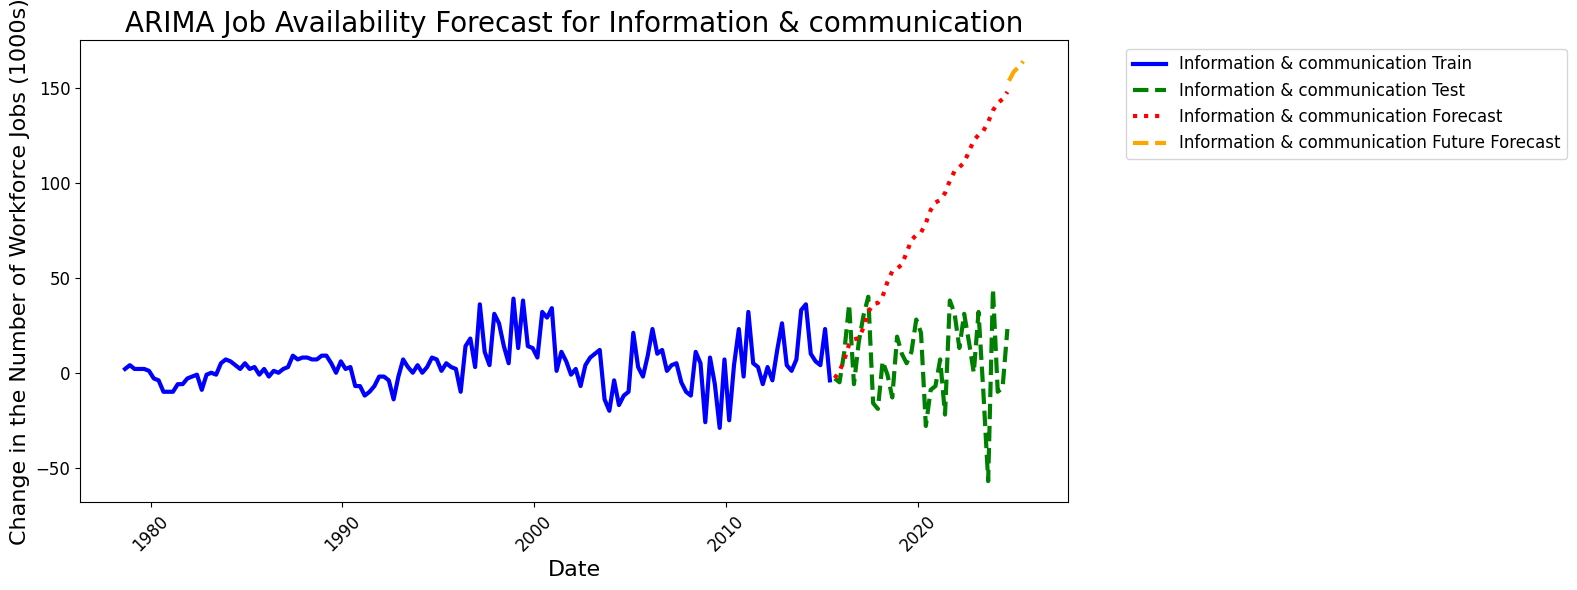

In [822]:
def plot_specific_sector(sector_name):
    plt.figure(figsize=(16,6))

    # Plotting the training data
    if sector_name in train.columns:
        plt.plot(train.index, train[sector_name], label=f'{sector_name} Train', linewidth=3, color='blue')

    # Plotting the test data
    if sector_name in test.columns:
        plt.plot(test.index, test[sector_name], label=f'{sector_name} Test', linestyle='--', linewidth=3, color='green')

    # Plotting the forecast data
    if sector_name in sector_forecasts:
        forecast_data = sector_forecasts[sector_name]
        forecast_test = forecast_data[:len(test)]
        forecast_future = forecast_data[len(test):]
        plt.plot(test.index, forecast_test, label=f'{sector_name} Forecast', linestyle=':', linewidth=3, color='red')

    # Plotting Future Forecast
    if not forecast_future.empty:
        future_index = pd.date_range(start=test.index[-1] + pd.Timedelta(days=1), periods=len(forecast_future), freq='Q')
        plt.plot(future_index, forecast_future, label=f'{sector_name} Future Forecast', linestyle='--', linewidth=3, color='orange')

    plt.title(f'ARIMA Job Availability Forecast for {sector_name}', fontsize=20)
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Change in the Number of Workforce Jobs (1000s)', fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.legend(bbox_to_anchor = (1.05,1), loc='upper left', fontsize=12)
    plt.tight_layout()
    plt.savefig(f'ARIMA Forecast for {sector_name} - Labour Market Overview')
    plt.show()

plot_specific_sector('Information & communication')

In [ ]:
for sector in sectors:
    
    if sector not in sector_forecasts:
        print(f"Forecast for sector '{sector}' not found... skipping")
        continue
    
    test_sector = test[sector].dropna()
    forecast_sector = sector_forecasts[sector].dropna()
    
    minimum_length = min(len(test_sector), len(forecast_sector))
    test_sector = test_sector[:minimum_length]
    forecast_sector = forecast_sector[:minimum_length]
    
    if test_sector.empty or forecast_sector.empty:
        print(f"Skipped sector '{sector}' due to missing data")
        continue

    # resets the indices to ensure alignment
    test_sector = test_sector.reset_index(drop=True)
    forecast_sector = forecast_sector.reset_index(drop=True)
    
    non_zero_indices = test_sector != 0 #needed this line as mape was initially very high and indicated a division by 0 error
    
    mse = mean_squared_error(test_sector, forecast_sector)
    mae = mean_absolute_error(test_sector, forecast_sector)
    rmse = np.sqrt(mse)
    r2 = r2_score(test_sector, forecast_sector)
    mape = mean_absolute_percentage_error(test_sector[non_zero_indices], forecast_sector[non_zero_indices])/100
    
    results.append({'Sector' : sector,
                   'MSE' : mse,
                   'MAE' : mae,
                   'RMSE': rmse,
                   'R2' : r2,
                   'MAPE': mape})
    
results_data_frame = pd.DataFrame(results)
results_data_frame = pd.DataFrame(results).drop_duplicates(subset=['Sector'])

print(results_data_frame)

                                               Sector           MSE  \
0                     Agriculture, forestry & fishing  7.699576e+02   
1                                  Mining & quarrying  2.844553e+06   
2                                       Manufacturing  3.254237e+09   
3   Electricity, gas, steam & air conditioning supply  1.039612e+03   
4   Water supply, sewerage, waste & remediation ac...  1.345746e+02   
5                                        Construction  2.417032e+03   
6   Wholesale & retail trade; repair of motor vehi...  2.154340e+04   
7                                 Transport & storage  8.834434e+03   
8             Accommodation & food service activities  3.479768e+04   
9                         Information & communication  7.135297e+03   
10                   Financial & insurance activities  1.099704e+03   
11                             Real estate activities  4.896892e+03   
12     Professional scientific & technical activities  1.277501e+05   
13    

In [824]:
data_frame = data_frame_copy

In [825]:
# Create XGBoost Function

# Step 1: Feature Engineering

# Adjust data_frame to deal with lags for XGBoost

lags = [1,3,6,12] # Corresponds with the months in the year as the results are every 3 months starting from March
lagged_df = data_frame.copy()

y = data_frame.shift(-4) # Changed from -40 to -4
# Predicts for next 10 years, not implementing recursive forecasting yet but I will be once model is done

lagged_features = []
for lag in lags:
    for column in data_frame.columns:
        lagged_features.append(data_frame[column].shift(lag).rename(f'{column}_lag{lag}'))

lagged_df = pd.concat(lagged_features, axis=1)
xgb_df = pd.concat([data_frame, lagged_df], axis=1)
xgb_df = xgb_df.dropna() # Drops NaNs values that can occur from the shift
    
                               
rolling_features = []
    
for column in data_frame.columns:
    for window in [3,6,12]: #implements rolling statistical figures (i.e.: mean and standard deviation) within 3, 6 and 12 months
        rolling_features.append(data_frame[column].rolling(window).mean().rename(f'{column}_mean_{window}'))
        rolling_features.append(data_frame[column].rolling(window).std().rename(f'{column}_std_{window}'))
    rolling_features.append(data_frame[column].pct_change(periods=12).rename(f'{column}_yearly_percentage_change'))

rolling_df = pd.concat(rolling_features, axis=1)

data_frame = pd.concat([data_frame, rolling_df], axis=1)

data_frame = data_frame.dropna()

In [826]:
# Implement Train-Test Split

X = xgb_df.drop(columns=data_frame.columns[:len(y.columns)])
y = y.iloc[:170] # before it was [:134] for the 10-year prediction
X = X.iloc[:-4] # Changed from -40 to -4

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [827]:
# Hyperparameter grid for Random Search

parameter_grid = {'n_estimators': np.arange(100,1000,100),
                 'learning_rate':np.linspace(0.001,0.5,10),
                 'max_depth': np.array([3,5,7,9,11,13]),
                 'subsample':np.linspace(0.7,1,10),
                 'colsample_bytree':np.linspace(0.5,1,6),
                 'min_child_weight': np.array([1,3,5,10]),
                 'gamma': np.array([0,0.1,0.2,0.3]),
                 'reg_alpha':[0,0.01,0.1],
                 'reg_lambda':[0,0.01,0.1]}

In [828]:
# Implement XGBoost Model

model = xgb.XGBRegressor(objective = "reg:squarederror")

xgb_forecasts = {}
best_models = {} #stores best models for each sector

for sector in y.columns:
    random_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=parameter_grid, 
        cv=5, 
        scoring = 'neg_mean_squared_error',
        n_iter=50, 
        verbose=2, 
        random_state=42, 
        n_jobs=-1
    )
    
    random_search.fit(X_Train, Y_Train[sector])
    best_model = random_search.best_estimator_
    best_models[sector] = best_model
    xgb_forecasts[sector] = best_model.predict(X_Test)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 5 folds for each of 50 candidates, totalling 250 fits
Fitting 

In [829]:
# Implement Recursive Forecasting -> Good for predicting for a very large amount of values such as 40 in this case for predicting the next 10-years

future_steps = 4 #changed from 40 to 4 because I am only predicting for a year now - if I have enough time, change to 40 so I can predict for next 10 years
future_predictions = {}

for sector in y.columns:
    future_predictions[sector]=[] #stores future predictions based on sector
    
    best_model = best_models[sector] # Get the best model for the respective sector
    current_input = X_Train.iloc[-1,:].values # starts with last known data point

    for _ in range(future_steps):
        # Predict the next step
        next_prediction = best_model.predict(current_input.reshape(1,-1))[0]
        future_predictions[sector].append(next_prediction)

        # Update current_input for the next iteration and shift it by removing the oldest feature and adding the new prediction
        current_input = np.roll(current_input,-1)
        current_input[-1] = next_prediction

# Add results to data frame
future_dataframe = pd.DataFrame(future_predictions)
print(future_dataframe)

   Agriculture, forestry & fishing  Mining & quarrying  Manufacturing  \
0                       372.703766           70.999916    2545.886475   
1                       406.395844          256.735962    3359.268799   
2                       473.804749          238.463852    4094.127441   
3                       433.671478          290.369171    3725.824951   

   Electricity, gas, steam & air conditioning supply  \
0                                         125.743942   
1                                         182.553650   
2                                         185.147720   
3                                         178.277191   

   Water supply, sewerage, waste & remediation activities  Construction  \
0                                         195.842041        2048.952637   
1                                         174.823700        2268.212402   
2                                         158.365036        1857.335693   
3                                         178.273514 

In [830]:
# Implement Evaluation Metrics

for sector in Y_Test.columns:
    mae = mean_absolute_error(Y_Test[sector], xgb_forecasts[sector])
    mse = mean_squared_error(Y_Test[sector], xgb_forecasts[sector])
    rmse = np.sqrt(mse)
    r2 = r2_score(Y_Test[sector], xgb_forecasts[sector])
    mape = mean_absolute_percentage_error(Y_Test[sector], xgb_forecasts[sector])

    print(f"Evaluation Metrics for {sector}")
    print(f"Mean absolute error: {mae}")
    print(f"Mean squared error: {mse}")
    print(f"Root mean squared error: {rmse}")
    print(f"R2: {r2}")
    print(f"Mean Absolute Percentage Error: {mape}")
    print("." * 30) # To seperate the results for better readability

Evaluation Metrics for Agriculture, forestry & fishing
Mean absolute error: 17.69560421214384
Mean squared error: 420.30623675480155
Root mean squared error: 20.50137158228204
R2: 0.02444340768650688
Mean Absolute Percentage Error: 0.044204911461600375
..............................
Evaluation Metrics for Mining & quarrying
Mean absolute error: 9.56066198909984
Mean squared error: 131.69324444501956
Root mean squared error: 11.475767706128403
R2: -2.7674129668747707
Mean Absolute Percentage Error: 0.15972809550369643
..............................
Evaluation Metrics for Manufacturing
Mean absolute error: 52.43917308134191
Mean squared error: 4593.418820417979
Root mean squared error: 67.77476536601199
R2: -0.623947653270817
Mean Absolute Percentage Error: 0.019684744445556856
..............................
Evaluation Metrics for Electricity, gas, steam & air conditioning supply
Mean absolute error: 12.229671702665442
Mean squared error: 224.5161246836206
Root mean squared error: 14.983

C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\3815293994.py:4: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_index = pd.date_range(start=test_index[-1]+pd.DateOffset(months=3), periods=future_steps, freq='Q')


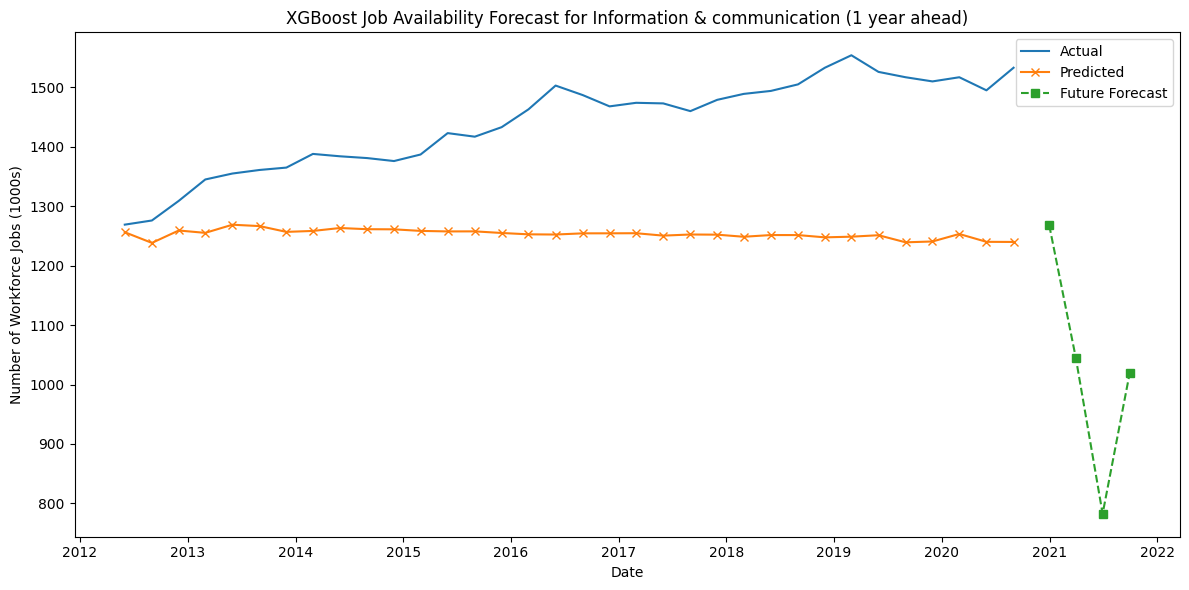

In [831]:
tech_sector = 'Information & communication'

test_index = y.index[-len(Y_Test):] # provides the time period of the test set
future_index = pd.date_range(start=test_index[-1]+pd.DateOffset(months=3), periods=future_steps, freq='Q')

plt.figure(figsize=(12,6))
plt.plot(test_index, Y_Test[tech_sector], label='Actual')
plt.plot(test_index, xgb_forecasts[tech_sector], label='Predicted', marker='x')
plt.plot(future_index, future_predictions[tech_sector], label='Future Forecast', linestyle='--', marker='s')

plt.title(f'XGBoost Job Availability Forecast for {tech_sector} (1 year ahead)')
plt.xlabel('Date')
plt.ylabel('Number of Workforce Jobs (1000s)')
plt.legend()
plt.tight_layout()
plt.show()

In [832]:
data_frame = data_frame_copy

print(data_frame)

            Agriculture, forestry & fishing  Mining & quarrying  \
Year-Month                                                        
1978-06-01                              520                 383   
1978-09-01                              512                 376   
1978-12-01                              512                 373   
1979-03-01                              507                 374   
1979-06-01                              509                 374   
...                                     ...                 ...   
2023-09-01                              377                  51   
2023-12-01                              403                  50   
2024-03-01                              372                  48   
2024-06-01                              350                  50   
2024-09-01                              361                  46   

            Manufacturing  Electricity, gas, steam & air conditioning supply  \
Year-Month                                      

In [833]:
# Create LSTM model

# Step 1 : Set a seed -> Your evaluation metrics and graph would start changing each time otherwise

os.environ['PYTHONHASHSEED']=str(42)
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
forecast_steps = 4
forecast = []


# Step 2 : Normalise Data -> we need to do this as LSTMs are sensitive to scale

scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data_frame.values)
scaled_df = pd.DataFrame(scaled_data, index=data_frame.index, columns=data_frame.columns) #should have values between 0 and 1

In [834]:
# Step 3 -> Create a time-series sequence

def create_sequences(data, window_size=4):
    X, y = [],[]
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Code whwn predicting 1 value into future
# def create_sequences(data, window_size=4):
#     X, y = [],[]
#     for i in range(len(data)-window_size):
#         X.append(data[i:i+window_size])
#         y.append(data[i+window_size])
#     return np.array(X), np.array(y)

X, y = create_sequences(scaled_df['Information & communication'])
y=y.reshape(-1,1)

print(X.shape, y.shape)

(182, 4) (182, 1)


C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\989315518.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y.append(data[i])


In [835]:
# Step 4 -> Build LSTM Model

X = X.reshape((X.shape[0], X.shape[1], 1))

model=Sequential()
model.add(LSTM(128, activation='elu', input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(y.shape[1])) #output layer
#model.add(LeakyReLU(alpha=0.01))
model.compile(optimizer='rmsprop', loss='mse')

model.summary()

# when predicting for just one value activation was linear, optimiser was adam and loss was mse

c:\Users\M D'costa\Documents\University of Bath Third Year Project\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_33 (LSTM)                  │ (None, 128)            │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 66,689 (260.50 KB)

 Trainable params: 66,689 (260.50 KB)

 Non-trainable params: 0 (0.00 B)

In [836]:
# Step 5 -> Train Model using Train Test Split

split = int(0.8*len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

# implement a time-series split
time_series_split_CV = TimeSeriesSplit(n_splits=10)

for train_index, test_index in time_series_split_CV.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

# best for 1 year forecast is epoch=40
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=40, batch_size=16, shuffle=False) 

# when implementing just one future step...
#200 epochs is the best so far; 200 for epoch, 16 for batch size (if we use rolling features) -> without rolling feature is 85 epoch and 16 for batch-size

X_train shape: (145, 4, 1)
y_train shape: (145, 1)
Epoch 1/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0240 - val_loss: 0.0487
Epoch 2/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0333 - val_loss: 0.0091
Epoch 3/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0316 - val_loss: 0.0031
Epoch 4/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0204 - val_loss: 0.0014
Epoch 5/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0121 - val_loss: 0.0014
Epoch 6/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0052 - val_loss: 0.0029
Epoch 7/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0018 - val_loss: 0.0016
Epoch 8/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0017 - val_loss: 0.0023
Epoch 9/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0013 - val_loss: 0.0023
Epoch 10/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0012 - val_loss: 0.0015
Epoch 11/40
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 9.6897e-04 - val_loss: 0.0031
Epoch 12/40
11/11 

In [837]:
# Step 6 -> Forecasting

last_sequence = X_test[-1] # starts from the last known sequence
current_sequence = last_sequence

for _ in range(forecast_steps):
    predictions = model.predict(current_sequence[np.newaxis, :, :])[0]
    forecast.append(predictions)

    current_sequence = np.vstack([current_sequence[1:], predictions])

forecast = np.array(forecast)

# Step 7 -> Inverse Transform to original scale

full_inverse = np.zeros((forecast.shape[0], scaled_df.shape[1]))
full_inverse[:, scaled_df.columns.get_loc('Information & communication')] = forecast[:, 0]
original_scale = scaler.inverse_transform(full_inverse)[:, scaled_df.columns.get_loc('Information & communication')]

# Code when I was just predicting 1 value into future
# predictions = model.predict(X_test)

# # Implementing Inverse Scale

# y_test_inverse = scaler.inverse_transform(y_test)
# predictions_inverse = scaler.inverse_transform(predictions)

# sector = "Information & communication"
# sector_index = data_frame.columns.get_loc(sector)

# plt.plot(y_test_inverse[:,sector_index], label='True')
# plt.plot(predictions_inverse[:,sector_index], label='Predicted')
# plt.title(f"Prediction for {sector}")
# plt.legend()
# plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


C:\Users\M D'costa\AppData\Local\Temp\ipykernel_10296\3624066015.py:3: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  future_dates = pd.date_range(start=dates[-1], periods= forecast_steps+1, freq='Q')[1:]


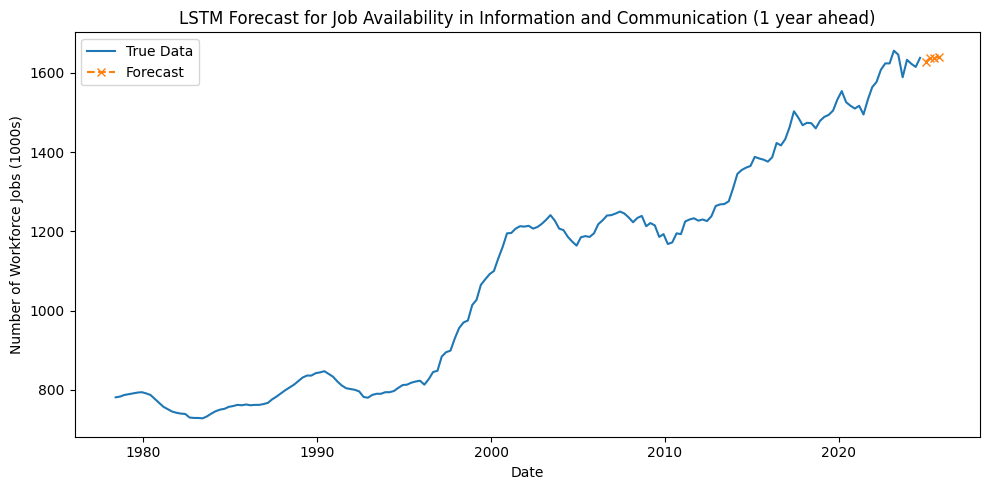

In [842]:
# Step 8 -> Plot Forecast
dates = data_frame.index[-len(y_test):]
future_dates = pd.date_range(start=dates[-1], periods= forecast_steps+1, freq='Q')[1:]

plt.figure(figsize=(10,5))
plt.plot(data_frame['Information & communication'], label='True Data')
plt.plot(future_dates, original_scale, label='Forecast', linestyle= '--', marker='x')
plt.title(f"LSTM Forecast for Job Availability in Information and Communication (1 year ahead)")
plt.xlabel('Date')
plt.ylabel('Number of Workforce Jobs (1000s)')
plt.legend()
plt.tight_layout()
plt.show()

In [843]:
# Step 7 -> Get Evaluation Metrics
sector = "Information & communication"
sector_index = data_frame.columns.get_loc(sector)

#Reshape y_test and predictions to 2D -> makes sure that the data being passed to inverse transform is the correct shape
y_test_2d = np.repeat(y_test,data_frame.shape[1], axis = 1)

if predictions.shape == (1,):
    predictions_reshaped = np.repeat(predictions, y_test.shape[0], axis=0)
else:
    predictions_reshaped = predictions.reshape(-1)

# Reshape predictions to 2D -> makes sure that the data being passed to inverse transform is the correct shape
predictions_2d = np.repeat(predictions_reshaped.reshape(-1,1),data_frame.shape[1], axis=1)

# Applies an inverse transform on reshaped data
true_inverse = scaler.inverse_transform(y_test_2d)
predictions_inverse = scaler.inverse_transform(predictions_2d)

y_true_sector = true_inverse[:, sector_index]
y_predictions_sector = predictions_inverse[:, sector_index]

if y_true_sector.shape != y_predictions_sector.shape:
    raise ValueError(f"Shapes of y_true_sector and y_predictions_sector are inconsistent: {y_true_sector.shape} vs {y_predictions_sector.shape}")

mse = mean_squared_error(y_true_sector, y_predictions_sector)
mae = mean_absolute_error(y_true_sector, y_predictions_sector)
rmse = np.sqrt(mse)
r2 = r2_score(y_true_sector, y_predictions_sector)
mape = mean_absolute_percentage_error(y_true_sector, y_predictions_sector)


# Code when I initially implemented for 1 step
# y_true_sector = y_test_inverse[:, sector_index]
# y_predictions_sector = predictions_inverse[:,sector_index]
# mse = mean_squared_error(y_true_sector, y_predictions_sector)
# mae = mean_absolute_error(y_true_sector, y_predictions_sector)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_true_sector, y_predictions_sector)

print(f"Evaluation metrics for {sector}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")
print(f"R2: {r2:.4f}")
print(f"Mean Absolute Percentage Error: {mape:.4f}")

Evaluation metrics for Information & communication
Mean Squared Error: 5081.9017
Mean Absolute Error: 52.7847
Root Mean Squared Error: 71.2875
R2: -0.9912
Mean Absolute Percentage Error: 0.0342
